# Contextually Supervised Source Separation (CSSS)
This packages deploys contextually supervised source separation (CSSS) techniques in python. CSSS was originally decribed by Wytock and Kolter in [1] and we follow their original notation in this docuemntation.  We also include updates and extensions of the origianl CSSS method as created by the authors of this package in their applied work [2-4]. 	

CSSS is the disaggregation of a time series of source signals from observations of their sum. The below equation displays this problem where the vector $\bar y$ is observed and each source signal, $y_i$ is unobserved. 
\begin{equation}
\bar y = \sum_{i=0}^{k} y_i
\end{equation}

Contextual separation is achieved by (A) relating each source signal to exogenous observations, and (B) exploiting known regularity in the source signals. 
The equation below displays the general form of this optimization as presented in [1]. $\ell_i()$ is a cost function to fit the source signal, $y_i$ to the exogenous variables, $X_i$, using a linear transformation with parameters $\theta_i$; $g_i()$ is a regularization term applied to the source signal which would elicit smoothness or other periodic regularity; and $h_i()$ is a regularization term for the parameters $\theta_i$. 

\begin{align}
\min_{Y,\theta}\hspace{5mm}& \sum_{i=0}^{k} \{ \ell_i(y_i, X_i \theta_i) + g_i(y_i) + h_i(\theta_i)\}\\
\mbox{s.t.,}\hspace{5mm}&  \bar y = \sum_{i=0}^{k} y_i
\end{align}


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cvxpy 
import csss as CSSS
import time 
%matplotlib inline

# Tutorial Data
We generate a basic set of data for this tutorial. 
The source signals, Y1 and Y2 are constucted by adding white noise to univariate context variables: X1, and X2. 
- X1 contains a sin wave (period 10, amplitude 50) and an intercept term of 10. 
- X2 is a trend that increases linearly with time. 

In [2]:
## Create an example case where we separate two signals based on sin functions. 
N = 10

### Generate signal Y1 from covaraites X11 and X12
X12 = np.sin(np.arange(N)*2*np.pi/N)*50 
X11 = np.ones(N)
X1  = np.vstack([X11,X12]).transpose()
Y1  = X1[:,0] * 10 + X1[:,1] + np.random.normal(0,4,N) 

## Generate signal Y2 from covariates X2
X2 = np.array([5*elem+2 for elem in range(0,N)])
Y2 = X2 + np.random.normal(0,5,N)

## Generate Aggregate Signal, Y
Y = Y1 + Y2


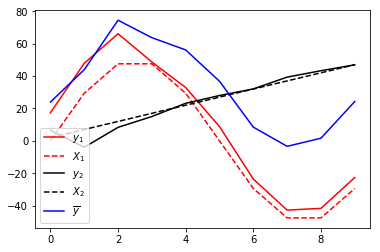

In [3]:
## Plot 
plt.plot(Y1, 'r',   label='$y_1$')
plt.plot(X1[:,1], 'r--', label='$X_1$')
plt.plot(Y2, 'k',   label='$y_2$',)
plt.plot(X2, 'k--', label='$X_2$')


plt.plot(Y,'b',label='$\overline{y}$')
plt.legend(loc = 3)


## CSSS Object
The CSSS package is built upon the CSSS object class, which allows users to fully specifcy and fit a problem. 

A CSSS objest is initailized with only a source signal for disaggregation, in this case the numpy array, Y. 


### Attributes
- `models` is a dictionary of models for each component source.  Adding sources and their properties is addressed below. 
- `constraints` is a list of additional constraints. Adding constraints is addressed below. 
- `aggregateSignal` is the aggregate signal
- `N` is the number of observations in the aggregate signal. 
- `modelcounter` is the total number of source models included.


In [4]:
## A CSSS Object is initialized with an aggregate signal
CSSEtry = CSSS.CSSS( aggregateSignal=Y)

### Adding Sources
The method CSSS.addSource adds a model for a source signal. By default, the model cost function is the sum of square errors, $\left|\left| y_i - X_i \theta_i \right|\right|_2^2$_, and there is no regularization of the source signal or the parameters. Alternate options for this form (i.e. other norms) will be included in future versions of this package. 
```python
CSSSobject.addSource(X1, name = 'y1')  ## Add a model for source signal y1 based on covaraite X1
CSSSobject.addSource(X2, name = 'y2')  ## Add a model for source signal y2 based on covaraite X2
```
The optional parameter `alpha` is a salar that weights the cost of the signal in the objective function. In the following example, costs associated with the errors in the model for `y1` will be weighted twice that of those for `y2`. 


In [5]:
# Try it out. 
CSSEtry = CSSS.CSSS(Y)  ## Instantiate model with aggregate signal, Y
CSSEtry.addSource(X1, alpha = 1, name = 'y1')  ## Add a model for Y1
CSSEtry.addSource(X2, alpha = 1, name = 'y2')  ## Add a model for Y2y
## Perform a fitting of this initial model usign 
# CSSS.constructSolve()
start=time.time()
CSSEtry.constructSolve()
print(time.time()-start)


0.0765829086304


## Deconstructing the model
Now that the model is fit 

In [6]:
## Models is a dictionary of models for each source signal. 
print(CSSEtry.models.keys())

## A Model element is itself a dictioanry
print(CSSEtry.models['y1'].keys())

## Elements include all cvxpy variables and data associated with the signal, including
# regressor: X1
# theta: cvxpy Varaible vector of coefficients, theta_1
# source" cvxpy Variable vector of the source signal, Y1

## Now that the model is fit. we can access the fitted values. 
print('\ntheta_1')
print(CSSEtry.models['y1']['theta'].value)

print('\nY_1')
print(CSSEtry.models['y1']['source'].value)
print('\nX1')
print(Y1)
print(Y2)
print(Y)


['y1', 'y2']
['regularizeSource', 'lb', 'name', 'regressor', 'regularizeTheta', 'source', 'beta', 'obj', 'theta', 'alpha', 'costFunction', 'order', 'gamma', 'ub']

theta_1
[[19.36443684]
 [ 0.86134584]]

Y_1
[[ 21.09727138]
 [ 42.34505985]
 [ 64.04562896]
 [ 57.27436429]
 [ 44.28272728]
 [ 20.56476078]
 [ -7.64382518]
 [-22.77571336]
 [-21.65414848]
 [ -3.89175707]]

X1
[ 17.32517712  47.85945932  66.09974864  48.65730806  32.93477377
   8.79892844 -23.58749982 -42.73015303 -41.65293576 -22.62955526]
[ 6.61698475 -3.95526134  8.3404874  15.02138235 23.18602007 27.98059964
 32.04486432 39.34928119 43.29557788 46.93217893]
[23.94216187 43.90419798 74.44023604 63.67869041 56.12079385 36.77952808
  8.4573645  -3.38087184  1.64264212 24.30262367]


#### Parameter Regularization
The `regularizeTheta` input to `addSource` defines the $h_i()$ term for the source and takes either a string or a function. Strings define standard regularizations and can take "ss" for sum of squares, 'l1' for l1-norms, and 'l2' for l2-norms. `beta` is a parameter for linearly scaling the regularization term in the overall objective function. `beta` is a linear scaling for the regularization in the objective function. `beta`  may take a scalar or a vector value, if a vector there must be one element for element of $\theta_i$.



If inputing a custom function to regularize theta, the function must input a vector of cvxpy variables, and output a scalar that goes into the objective function, and must be convex. The `beta` term can still be used to scale this function. 
```python
import cvxpy




In [7]:
## Create a custom regularization function that penalized the square distance from a value to 2. 
def customReg(x):
    return(cvxpy.sum_entries(cvxpy.power((x-5),2)))

CSSEtry2 = CSSS.CSSS(Y)  ## Instantiate model with aggregate signal, Y
CSSEtry2.addSource(X2, alpha = 1, name = 'y2')  ## Add a model for Y2
CSSEtry2.addSource(X1, name = 'y1', regularizeTheta=customReg, beta = 2000)  ## Add a model for source signal y1


In [8]:
## Fit the model
# This time tryign with ADMM in place of a one step solver. 
import time
start=time.time()
CSSEtry2.constructSolve()
#print(time.time()-start)

23267.590366114506

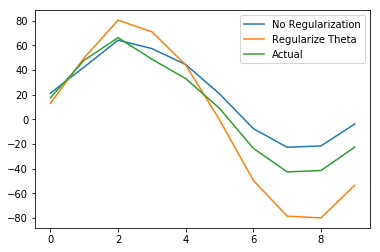

In [9]:
plt.plot(CSSEtry.models['y1']['source'].value,  label = 'No Regularization')
plt.plot(CSSEtry2.models['y1']['source'].value, label = 'Regularize Theta')

#plt.plot(CSSEtry.models['Y1']['regressor'] * CSSEtry.models['Y1']['theta'].value, label = 'Modeled')
plt.plot(Y1, label = 'Actual')

plt.legend()
plt.show()

## Regularizing a source
The `regularizeSource` input to `addSource` defines the $g_i()$ term for the source and takes either a string or a function. Strings define standard regularizations and can take "diff21_ss" for sum of squares of the differenced signal. `gamma` is a parameter for linearly scaling the regularization term in the overall objective function.  `gamma`  may take a scalar or a vector value, if a vector there must be one element for element of $\theta_i$.


In [10]:
## Create a custom regularization function that penalized the square distance from a value to 2. 
CSSEtry3 = CSSS.CSSS(Y)  ## Instantiate model with aggregate signal, Y
CSSEtry3.addSource(X2, alpha = 1, name = 'y2')  ## Add a model for Y2
CSSEtry3.addSource(X1, name = 'y1', regularizeSource='diff1_ss', gamma = 1)  ## Add a model for source signal y1
CSSEtry3.constructSolve()

1786.1088463756125

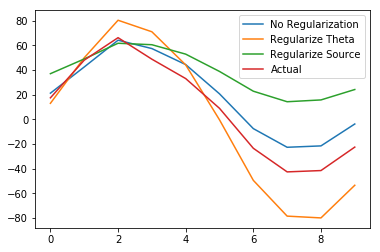

In [11]:
plt.plot(CSSEtry.models['y1']['source'].value,  label = 'No Regularization')
plt.plot(CSSEtry2.models['y1']['source'].value, label = 'Regularize Theta')
plt.plot(CSSEtry3.models['y1']['source'].value, label = 'Regularize Source')

#plt.plot(CSSEtry.models['Y1']['regressor'] * CSSEtry.models['Y1']['theta'].value, label = 'Modeled')
plt.plot(Y1, label = 'Actual')

plt.legend()
plt.show()

## ADMM Solver
There is also a built in ADMM solver (by Emre) 
It does not seem to be working, and I haven't used it before so I can't troubleshoot it (MT). 


In [12]:
# Try it out. 
CSSEtry = CSSS.CSSS(Y)  ## Instantiate model with aggregate signal, Y
CSSEtry.addSource(X1, alpha = 1, name = 'Y1')  ## Add a model for Y1
CSSEtry.addSource(X2, alpha = 1, name = 'Y2')  ## Add a model for Y2

## Perform a fitting of this initial model usign 
# CSSS.constructSolve()
start=time.time()
[dual_obj,norm_resid_equality,u]=CSSEtry.admmSolve(10, MaxIter=100, ABSTOL=0.001, RELTOL=0.01,verbose=True)
print(time.time()-start)


Verbose on
Initialized all sources
('iter_num', 's_norm', 'eps_dual', 'r_norm', 'eps_pri')
(1, 29.512232692955273, 0.05792763350816601, 0.5619558270059712, 0.0017320508075688772)
(2, 21.71073382745937, 0.09825183516958323, 0.4032440322482114, 0.0017320508075688772)
(3, 16.150320915634296, 0.12719265257139284, 0.28941813420266344, 0.0017320508075688772)
(4, 12.239553612964679, 0.14777424357551477, 0.20584631135388914, 0.0017320508075688772)
(5, 9.573184357303791, 0.1623279109401108, 0.14561009842051273, 0.0017320508075688772)
(6, 7.774889416270251, 0.17261130365737656, 0.10298714915653809, 0.0017320508075688772)
(7, 6.617984290134655, 0.17968884134861507, 0.07107309813780655, 0.0017320508075688772)
(8, 5.91278779576022, 0.18450412761196391, 0.04869824733385252, 0.0017320508075688772)
(9, 5.462245007037557, 0.1876287190516831, 0.03223059511128466, 0.0017320508075688772)
(10, 5.188643684424255, 0.1895422130518309, 0.020911913034947657, 0.0017320508075688772)
(11, 5.024096669288375, 0.1906

ValueError: x and y must not be None

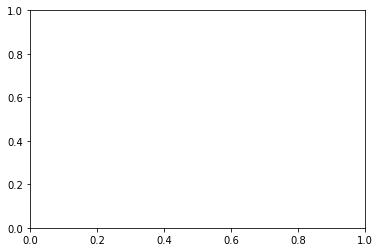

In [13]:
plt.plot(CSSEtry.models['Y2']['source'].value, label = 'ADMMDisaggregated')

#plt.plot(CSSEtry.models['Y2']['regressor'] * CSSEtry.models['Y2']['theta'].value, label = 'Modeled')
plt.plot(Y2, label = 'Actual')

plt.legend()
plt.show()

In [ ]:
plt.plot(Y, label = 'Actual Total')
plt.plot(CSSEtry.models['Y2']['source'].value+CSSEtry.models['Y1']['source'].value, '--<r',label = 'CSSS Total',)
plt.plot(CSSEtry.models['Y2']['admmSource']+CSSEtry.models['Y1']['admmSource'],'--ob', label = 'ADMM total',)

plt.legend()
plt.show()

In [ ]:
plt.plot(CSSEtry.models['Y2']['admmSource'], label = 'ADMMDisaggregated')
plt.plot(CSSEtry.models['Y1']['admmSource'], label = 'ADMMDisaggregated')
